In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset, Dataset

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
device = 'mps' if torch.backends.mps.is_available() else "cpu"
device

'mps'

#### Preparation Data

In [40]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

aug_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# train_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=aug_transform)
# train_dataset = ConcatDataset([train_dataset, train_dataset_aug])
# test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#---------------------------------------------------------------

image_folder_org = ImageFolder('./data/train_up/', transform=transform)
image_folder_aug = ImageFolder('./data/train_up/', transform=aug_transform)
train_dataset = ConcatDataset([image_folder_org, image_folder_aug])


class_name = ["airplane", "automobile", "bird","cat", "deer", "dog","frog","horse", "ship","truck"]
label_encoder = LabelEncoder()
y = pd.read_csv('./data/trainLabels.csv')
y_values = y['label'].values
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(y_values)
encoded_y = np.concatenate((encoded_y, encoded_y))


tensor_x = torch.stack([image for image, _ in train_dataset])
tensor_y = torch.tensor(encoded_y, dtype=torch.long)

train_dataset = TensorDataset(tensor_x, tensor_y)
test_dataset = ImageFolder(root='./data/test_up/', transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


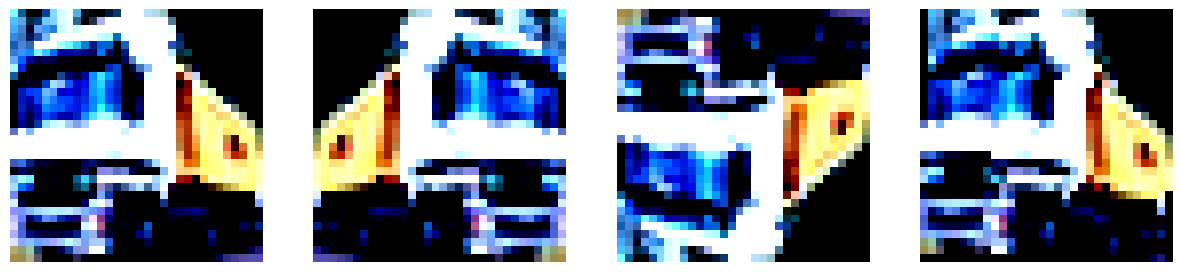

In [9]:
horizontal_flip = transforms.RandomHorizontalFlip(1)
vertical_flip = transforms.RandomVerticalFlip(1)
rotation = transforms.RandomRotation(degrees=15)

tensor = train_dataset[1][0]
tensor_horizontal_flip = horizontal_flip(tensor)
tensor_vertical_flip = vertical_flip(tensor)
tensor_rotation = rotation(tensor)

image = tensor.permute(1, 2, 0)
image_horizontal_flip = tensor_horizontal_flip.permute(1, 2, 0)
image_vertical_flip = tensor_vertical_flip.permute(1, 2, 0)
image_rotation = tensor_rotation.permute(1, 2, 0)

fig, ax = plt.subplots(ncols=4, figsize=(15, 4))
ax[0].imshow(image)
ax[0].axis(False)
ax[0].grid(False)

ax[1].imshow(image_horizontal_flip)
ax[1].axis(False)
ax[1].grid(False)

ax[2].imshow(image_vertical_flip)
ax[2].axis(False)
ax[2].grid(False)

ax[3].imshow(image_rotation)
ax[3].axis(False)
ax[3].grid(False)

plt.show()

In [41]:
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=2)

#### Init model

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Вход: 32x32, Выход: 32x32
        self.norm1 = nn.BatchNorm2d(32)
        self.drop1 = nn.Dropout2d(p=0.2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Вход: 32x32, Выход: 32x32
        self.norm2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Вход: 32x32, Выход: 16x16
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Вход: 16x16, Выход: 16x16
        self.norm3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Вход: 16x16, Выход: 8x8
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1)  # Вход: 8x8, Выход: 6x6
        self.norm4 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=4)  # Вход: 6x6, Выход: 1x1
        self.drop2 = nn.Dropout2d(p=0.2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=64, out_features=256)
        self.drop3 = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.norm1(x)
        x = self.drop1(x)
        x = F.relu(self.conv2(x))
        x = self.norm2(x)
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = self.norm3(x)
        x = self.pool2(x)
        x = F.relu(self.conv4(x))
        x = self.norm4(x)
        x = self.pool3(x)
        x = self.drop2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.drop3(x)
        x = self.fc2(x)
        return x

In [47]:
# def fit(model, opt, loss_func, train_loader, test_loader, epochs, scheduler):
def fit(model, opt, loss_func, train_loader, epochs, scheduler):
    train_loss = []
    test_loss = []
    history_accuracy = []

    for epoch in tqdm(range(epochs)):
        model.train()
        loss_sum = 0
        for xb, yb in tqdm(train_loader, desc=f"{epoch+1}'st Epoch Train"):
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            loss_sum += loss.item()
        train_loss.append(loss_sum / len(train_loader))
        scheduler.step()

        # model.eval()
        # loss_sum = 0
        # y_pred = []
        # y_true = []
        # with torch.no_grad():
        #     for x, y in tqdm(test_loader):
        #         x, y = x.to(device), y.to(device)
        #         output = model(x)
        #         logit = F.softmax(output, dim=1)
        #         _, pred = torch.max(logit, dim=1)
        #         y_pred.append(pred.item())
        #         y_true.append(y.item())
        #         loss = loss_func(output, y)
        #         loss_sum += loss.item()
        #     test_loss.append(loss_sum / len(test_loader))
        #     history_accuracy.append(accuracy_score(y_true, y_pred))

        last_train_loss = round(train_loss[-1], 5)
        # last_test_loss = round(test_loss[-1], 5)
        last_lr = scheduler.get_last_lr()
        # last_accuracy = round(history_accuracy[-1], 5)
        # print(f'Epoch {epoch+1}: Train Loss = {last_train_loss}, Test Loss = {last_test_loss}, Accuracy = {last_accuracy} Lr = {last_lr}')
        print(f'Epoch {epoch+1}: Train Loss = {last_train_loss}, Lr = {last_lr}')

    return train_loss, test_loss, history_accuracy

#### Train model

In [48]:
model = Net()
model.to(device)
loss_func = nn.CrossEntropyLoss()
opt = optim.Adam(params=model.parameters(), lr=0.001)
scheduler = lr_scheduler.MultiStepLR(opt, milestones=[10, 15, 18], gamma=0.5)

epochs = 20
# hist = fit(model, opt, loss_func, train_loader, test_loader, epochs, scheduler)
hist = fit(model, opt, loss_func, train_loader, epochs, scheduler)

  0%|          | 0/20 [00:00<?, ?it/s]

1'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1: Train Loss = 2.30978, Lr = [0.001]


2'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2: Train Loss = 2.30354, Lr = [0.001]


3'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3: Train Loss = 2.30349, Lr = [0.001]


4'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 4: Train Loss = 2.30295, Lr = [0.001]


5'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 5: Train Loss = 2.3029, Lr = [0.001]


6'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 6: Train Loss = 2.3028, Lr = [0.001]


7'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 7: Train Loss = 2.30298, Lr = [0.001]


8'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 8: Train Loss = 2.30279, Lr = [0.001]


9'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 9: Train Loss = 2.30277, Lr = [0.001]


10'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 10: Train Loss = 2.30272, Lr = [0.0005]


11'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 11: Train Loss = 2.30271, Lr = [0.0005]


12'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 12: Train Loss = 2.30274, Lr = [0.0005]


13'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 13: Train Loss = 2.30263, Lr = [0.0005]


14'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 14: Train Loss = 2.30268, Lr = [0.0005]


15'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 15: Train Loss = 2.30271, Lr = [0.00025]


16'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 16: Train Loss = 2.30264, Lr = [0.00025]


17'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 17: Train Loss = 2.30259, Lr = [0.00025]


18'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 18: Train Loss = 2.30257, Lr = [0.000125]


19'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 19: Train Loss = 2.30248, Lr = [0.000125]


20'st Epoch Train:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 20: Train Loss = 2.30242, Lr = [0.000125]


In [17]:
model = torch.load('./models/CIFAR_Net_model.pth', map_location='mps')
model.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout2d(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2, inplace=

#### Predict Test and Save Ans

In [49]:
def predict(model, loader):
    y_pred = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(loader):
            x = x.to(device)
            output = model(x)
            logit = F.softmax(output, dim=1)
            _, pred = torch.max(logit, dim=1)
            y_pred.append(pred.item())
    return y_pred

In [50]:
y_pred = predict(model, test_loader)

  0%|          | 0/300000 [00:00<?, ?it/s]

In [51]:
df_sub = pd.read_csv('./data/sampleSubmission.csv')
class_name = ["airplane", "automobile", "bird","cat", "deer", "dog","frog","horse", "ship","truck"]
df_sub['label'] = [class_name[i] for i in y_pred]
df_sub.to_csv('./ans/CIFAR_Net_ans.csv', index=False)